In [45]:
%load_ext autoreload
%autoreload 2
%pylab inline

from matplotlib.colors import ListedColormap
import pandas as pd
from scipy.spatial.distance import cdist
import seaborn as sns
from sklearn.base import clone
from sklearn.datasets import make_circles
from sklearn.model_selection import cross_validate, RepeatedStratifiedKFold
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from yellowbrick.classifier import ClassificationReport, ROCAUC, ConfusionMatrix, DecisionBoundariesVisualizer

from BEKML import BEMKL, poly_kernel, gauss_kernel, scoring


def plot_decision_boundaries(model, X_train, y_train,
                             X_test, y_test, ax=None):
    if ax is None:
        ax = plt.figure(figsize=(8, 8)).gca()
    dv = DecisionBoundariesVisualizer(model, classes=[0, 1, 2, 3])
    markers = next(dv.markers), next(dv.markers), next(dv.markers), next(dv.markers)
    colors = dv.colors
    dv = DecisionBoundariesVisualizer(model, classes=[-1, 1],
                                      ax=ax, step_size=0.025,
                                      show_scatter=False,
                                      pcolormesh_alpha=0.25)

    ax.scatter(*X_train[y_train==-1].T, color=colors[0],
               edgecolors='black', marker=markers[0], s=30,
               label='-train')
    ax.scatter(*X_train[y_train==1].T, color=colors[1],
               edgecolors='black', marker=markers[1], s=30,
               label='+train')
    ax.scatter(*X_test[y_test==-1].T, color=colors[2],
               edgecolors='black', marker=markers[2], s=30,
               label='-test')
    ax.scatter(*X_test[y_test==1].T, color=colors[3],
               edgecolors='black', marker=markers[3], s=30,
               label='+test')
    dv.fit_draw_poof(X_test, y_test)
    ax.legend()


def plot_kernel_importances(model, kernel_attrs, colormap):
    kernel_attrs = np.asarray(kernel_attrs)
    df = pd.DataFrame(np.c_[model.e_mu_orig, kernel_attrs],
                  columns=['e_mu', 'kernel', 'features', 'parameter'])\
       .astype({'e_mu': float, 'kernel': str,
                'features': str, 'parameter': float})

    g = sns.FacetGrid(df, col='kernel', size=4)
    vmin, vmax = df.e_mu.min(), df.e_mu.max()
    g.map_dataframe(
        lambda data, color: sns.heatmap(
            data.pivot("parameter", "features", "e_mu"),
            vmin=vmin, vmax=vmax, cmap=colormap
        ),
    )


def evaluate_model(model, X, y, kernel_attrs, divergent_cmap='YlOrRd'):
    X_train, X_test, y_train, y_test =\
        train_test_split(X, y, test_size=0.2, stratify=y)

    model.fit(X_train, y_train)
    
    plot_kernel_importances(model, kernel_attrs, divergent_cmap)
    
    fig = plt.figure(figsize=(8, 8))
    ax = fig.gca()
    model.plot_e(rug=True, kde=True, norm_hist=True, ax=ax,
                 rug_kws={'color': 'r', 'linewidth': 2,
                          'alpha':1})
    ax.set_title(r'$e_\mu$ distplot')

    fig = plt.figure(figsize=(8, 8))
    ax = fig.gca()
    model.plot_a(rug=True, kde=True, norm_hist=True, ax=ax,
                 rug_kws={'color': 'r', 'linewidth': 2,
                          'alpha':1})
    ax.set_title(r'$a_\mu$ distplot')
    
    fig = plt.figure(figsize=(8, 8))
    ax = fig.gca()
    cr = ClassificationReport(model, classes=[-1, 1], ax=ax,
                              cmap=divergent_cmap)
    cr.fit(X_train, y_train)
    cr.score(X_test, y_test)
    cr.poof()

    fig = plt.figure(figsize=(8, 8))
    ax = fig.gca()
    cm = ConfusionMatrix(model, classes=[-1, 1], ax=ax,
                         cmap=divergent_cmap)
    cm.fit(X_train, y_train)
    cm.score(X_test, y_test)
    cm.poof()
    
    fig = plt.figure(figsize=(8, 8))
    ax = fig.gca()
    rocauc = ROCAUC(model, classes=[-1, 1], ax=ax)
    rocauc.fit(X_train, y_train)
    rocauc.score(X_test, y_test)
    rocauc.poof()
    
    fig = plt.figure(figsize=(8, 8))
    ax = fig.gca()
    plot_decision_boundaries(model, X_train, y_train, X_test, y_test, ax=ax)

    model_cv = clone(model)
    scoring.iteration = 0
    folds = RepeatedStratifiedKFold(n_splits=3, n_repeats=2)
    return cross_validate(model_cv, X, y, cv=folds, scoring=scoring)


sns.set(style='ticks', context='talk')
np.set_printoptions(precision=4, linewidth=100)
N = 1000
D = 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


In [2]:
rbf_init, rbf_end = -3, 7
ply_init, ply_end = 1, 4

kernel_attrs = [('rbf', 'all', i) for i in range(rbf_init, rbf_end)]
kernels = [lambda A, B: gauss_kernel(A, B, 2**i)
           for i in range(rbf_init, rbf_end)]

kernel_attrs += [('poly', 'all', i) for i in range(ply_init, ply_end)]
kernels += [lambda A, B: poly_kernel(A, B, 0, i)
            for i in range(ply_init, ply_end)]

kernel_attrs += [('rbf', j, i) for i in range(rbf_init, rbf_end)
                 for j in range(D)]
kernels += [lambda A, B: gauss_kernel(A[:, j:j+1], B[:, j:j+1], 2**i)
            for i in range(rbf_init, rbf_end) for j in range(D)]

kernel_attrs += [('poly', j, i) for i in range(ply_init, ply_end)
                 for j in range(D)]
kernels += [lambda A, B: poly_kernel(A[:, j:j+1], B[:, j:j+1], 0, i)
            for i in range(ply_init, ply_end) for j in range(D)]
len(kernels), len(kernel_attrs)

(39, 39)

# Clean Data

,x1,x2,y
0,-0.673168,-0.727776,-1
1,0.066748,0.072615,1
2,-0.161750,0.972937,-1
3,-0.236898,-0.962543,-1
4,0.867892,-0.496890,-1


,x1,x2,y
count,1000.000000,1.000000e+03,1000.0000
mean,-0.000409,-7.529154e-08,0.0000
std,0.503004,5.024921e-01,1.0005
min,-1.018167,-1.018747e+00,-1.0000
25%,-0.104077,-1.035902e-01,-1.0000
50%,0.000356,-1.181573e-03,0.0000
75%,0.105037,1.040131e-01,1.0000
max,1.020014,1.014494e+00,1.0000


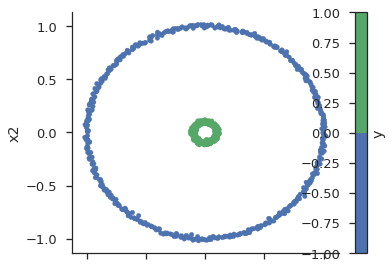

In [58]:
X, y = make_circles(N, factor=0.1, noise=0.01)
data = pd.DataFrame(X, columns=['x1', 'x2'])
y[y == 0] = -1
data['y'] = y

display(data.head())
display(data.describe())
cmap = [(0.29803921568627451, 0.44705882352941179, 0.69019607843137254),
        (0.33333333333333331, 0.6588235294117647, 0.40784313725490196)]
cmap = ListedColormap(cmap)
data.plot.scatter('x1', 'x2', c='y', cmap=cmap)
sns.despine()
plt.tight_layout()

## Sparse Model

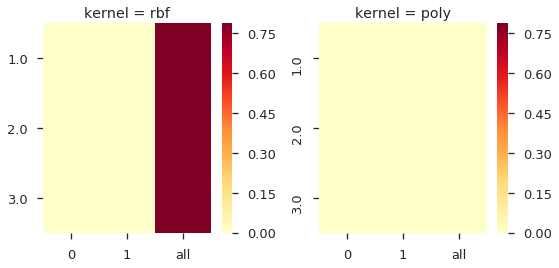

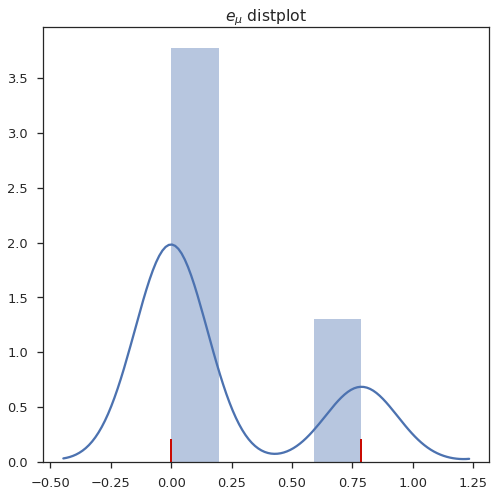

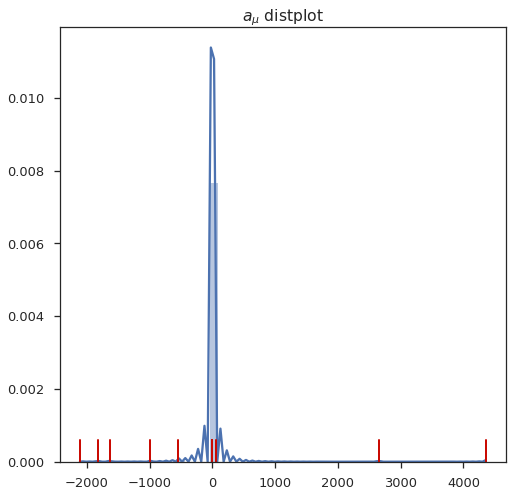

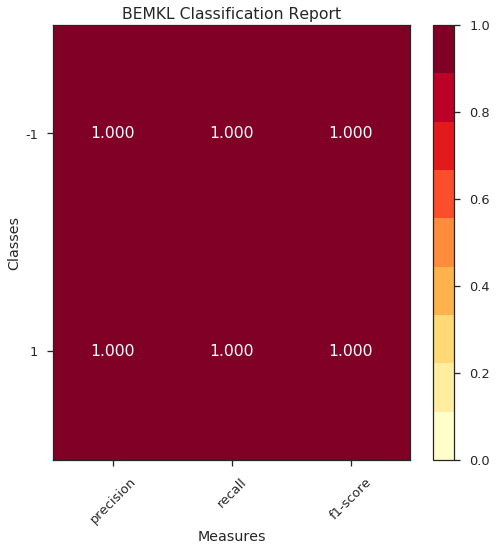

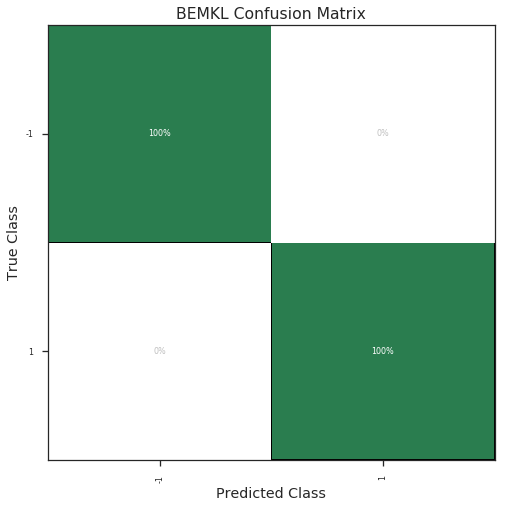

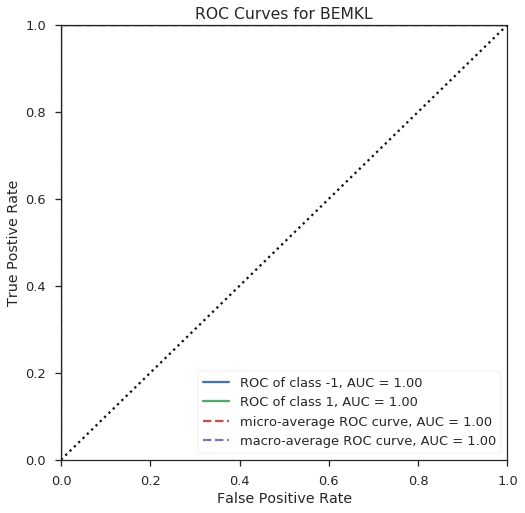

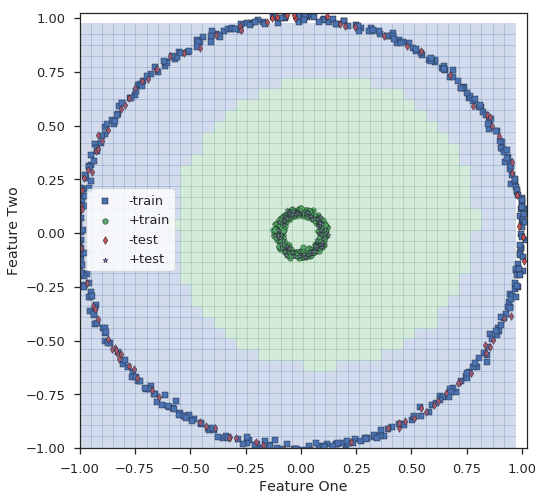

0 - Kernels: 10/39 (0.2564102564102564). SV: 634/666 (0.9519519519519519). Mean e: 0.8188. Median e: 0.8188. Std e: 0.0000. 
1 - Kernels: 10/39 (0.2564102564102564). SV: 634/666 (0.9519519519519519). Mean e: 0.8188. Median e: 0.8188. Std e: 0.0000. 
2 - Kernels: 30/39 (0.7692307692307693). SV: 647/666 (0.9714714714714715). Mean e: 0.2737. Median e: 0.0013. Std e: 0.3852. 
3 - Kernels: 30/39 (0.7692307692307693). SV: 647/666 (0.9714714714714715). Mean e: 0.2737. Median e: 0.0013. Std e: 0.3852. 
4 - Kernels: 30/39 (0.7692307692307693). SV: 648/668 (0.9700598802395209). Mean e: 0.2941. Median e: 0.0010. Std e: 0.4145. 
5 - Kernels: 30/39 (0.7692307692307693). SV: 648/668 (0.9700598802395209). Mean e: 0.2941. Median e: 0.0010. Std e: 0.4145. 
6 - Kernels: 30/39 (0.7692307692307693). SV: 657/666 (0.9864864864864865). Mean e: 0.2832. Median e: 0.0033. Std e: 0.3958. 
7 - Kernels: 30/39 (0.7692307692307693). SV: 657/666 (0.9864864864864865). Mean e: 0.2832. Median e: 0.0033. Std e: 0.3958. 


/home/mtambos/anaconda/envs/pml/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


{'fit_time': array([ 8.6248,  8.286 ,  8.5129,  8.3617,  7.9662,  8.3886]),
 'score_time': array([ 0.2904,  0.8855,  0.7831,  0.8119,  0.7801,  0.3411]),
 'test_score': array([ 0.9162,  0.8832,  0.9247,  0.8832,  0.9132,  0.9277]),
 'train_score': array([ 0.9084,  0.9204,  0.9057,  0.9204,  0.9084,  0.9042])}

In [59]:
sparse_model = BEMKL(kernels=kernels, alpha_lambda=1, beta_lambda=1, alpha_gamma=1,
                     beta_gamma=1, alpha_omega=1e-11, beta_omega=1e+9,
                     e_null_thrsh=1e-3, a_null_thrsh=1e-3)
evaluate_model(sparse_model, X, y, kernel_attrs)

## Non-Sparse Model

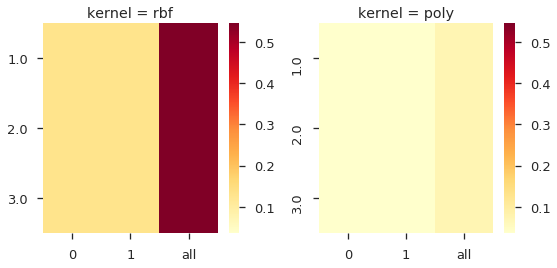

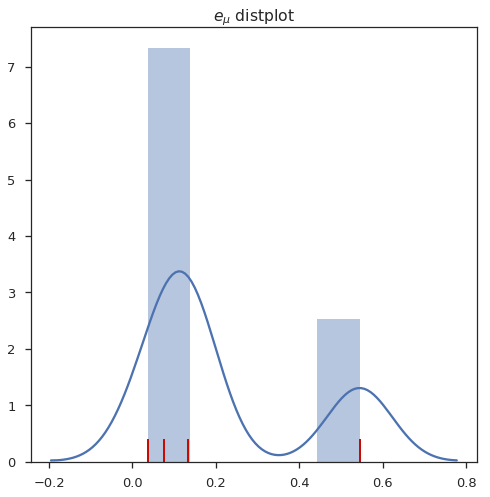

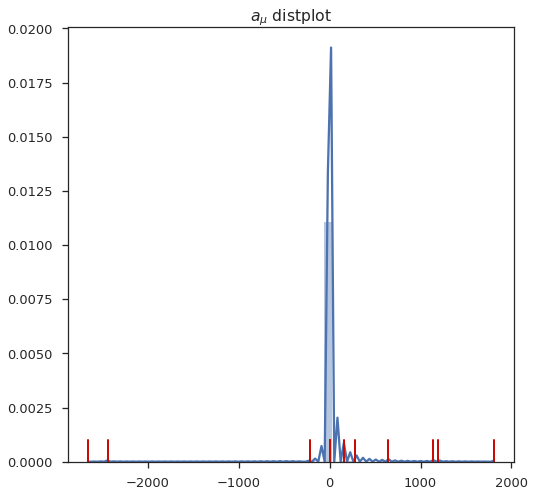

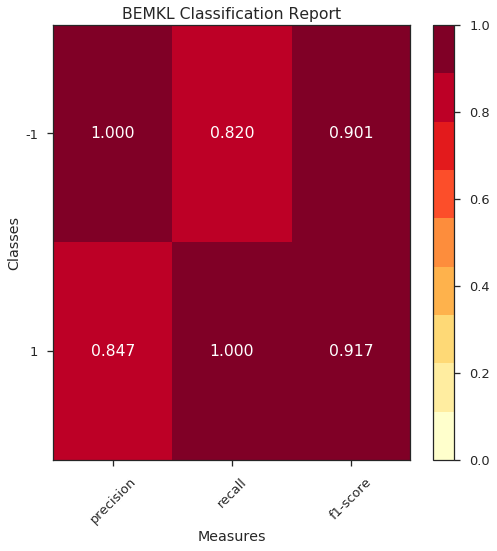

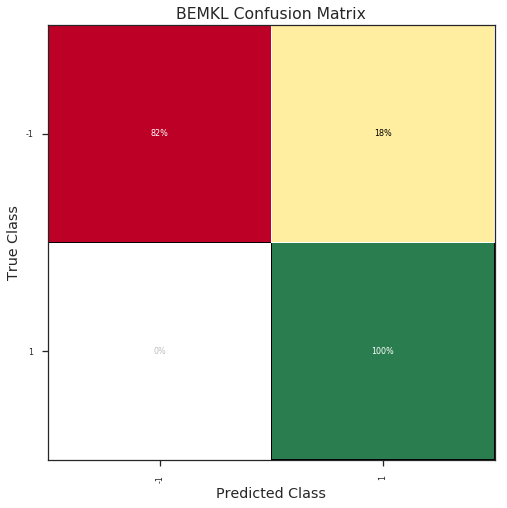

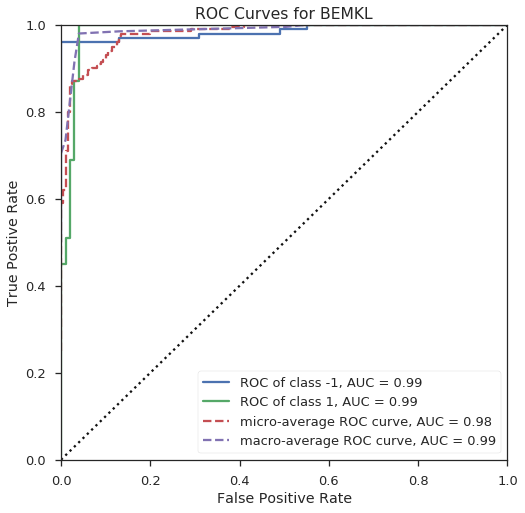

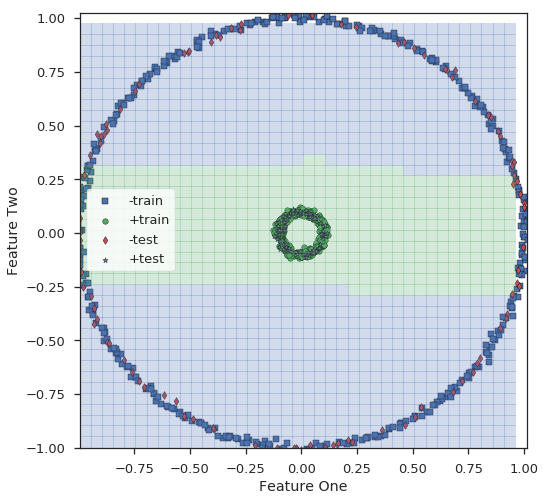

0 - Kernels: 39/39 (1.0). SV: 651/666 (0.9774774774774775). Mean e: 0.2433. Median e: 0.1667. Std e: 0.1666. 
1 - Kernels: 39/39 (1.0). SV: 651/666 (0.9774774774774775). Mean e: 0.2433. Median e: 0.1667. Std e: 0.1666. 
2 - Kernels: 39/39 (1.0). SV: 636/666 (0.954954954954955). Mean e: 0.2406. Median e: 0.1413. Std e: 0.2239. 
3 - Kernels: 39/39 (1.0). SV: 636/666 (0.954954954954955). Mean e: 0.2406. Median e: 0.1413. Std e: 0.2239. 
4 - Kernels: 39/39 (1.0). SV: 637/668 (0.9535928143712575). Mean e: 0.2251. Median e: 0.1636. Std e: 0.1966. 
5 - Kernels: 39/39 (1.0). SV: 637/668 (0.9535928143712575). Mean e: 0.2251. Median e: 0.1636. Std e: 0.1966. 
6 - Kernels: 39/39 (1.0). SV: 655/666 (0.9834834834834835). Mean e: 0.2394. Median e: 0.1617. Std e: 0.1871. 
7 - Kernels: 39/39 (1.0). SV: 655/666 (0.9834834834834835). Mean e: 0.2394. Median e: 0.1617. Std e: 0.1871. 
8 - Kernels: 39/39 (1.0). SV: 654/666 (0.9819819819819819). Mean e: 0.2461. Median e: 0.1754. Std e: 0.1796. 
9 - Kernels:

/home/mtambos/anaconda/envs/pml/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


{'fit_time': array([ 8.1796,  8.4384,  8.9564,  7.814 ,  9.2938,  8.2797]),
 'score_time': array([ 1.4075,  1.3001,  1.3012,  1.35  ,  1.5162,  1.3076]),
 'test_score': array([ 0.9012,  0.9222,  0.9096,  0.8892,  0.9162,  0.9277]),
 'train_score': array([ 0.9144,  0.9084,  0.9147,  0.9219,  0.9099,  0.9042])}

In [60]:
normal_model = BEMKL(kernels=kernels, alpha_lambda=1, beta_lambda=1, alpha_gamma=1,
                     beta_gamma=1, alpha_omega=1, beta_omega=1,
                     e_null_thrsh=1e-3, a_null_thrsh=1e-3)
evaluate_model(normal_model, X, y, kernel_attrs)

# Noisy Data

,x1,x2,y
0,-0.214987,0.027216,1
1,-1.272215,-0.752515,-1
2,0.890501,-0.429410,-1
3,0.859681,-0.609156,-1
4,0.187301,0.125894,1


,x1,x2,y
count,1000.000000,1000.000000,1000.0000
mean,-0.010397,-0.003707,0.0000
std,0.563142,0.560155,1.0005
min,-1.564815,-1.530222,-1.0000
25%,-0.351303,-0.351807,-1.0000
50%,0.007789,-0.013686,0.0000
75%,0.347559,0.361997,1.0000
max,1.401350,1.407891,1.0000


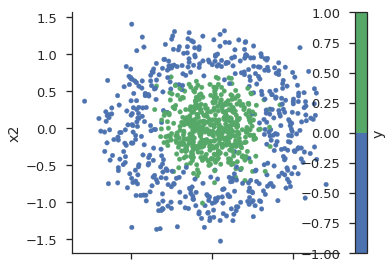

In [61]:
X, y = make_circles(N, noise=0.2, factor=0.3)
data = pd.DataFrame(X, columns=['x1', 'x2'])
y[y == 0] = -1
data['y'] = y
display(data.head())
display(data.describe())
cmap = [(0.29803921568627451, 0.44705882352941179, 0.69019607843137254),
        (0.33333333333333331, 0.6588235294117647, 0.40784313725490196)]
cmap = ListedColormap(cmap)
data.plot.scatter('x1', 'x2', c='y', cmap=cmap)
sns.despine()
plt.tight_layout()

## Sparse Model

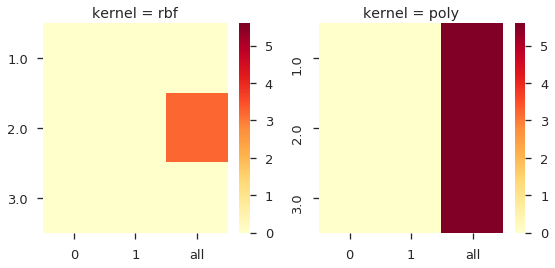

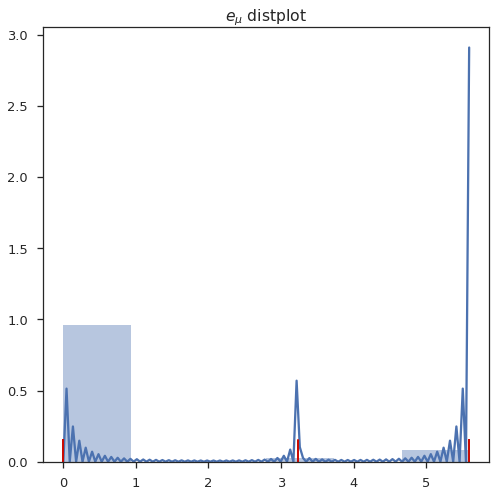

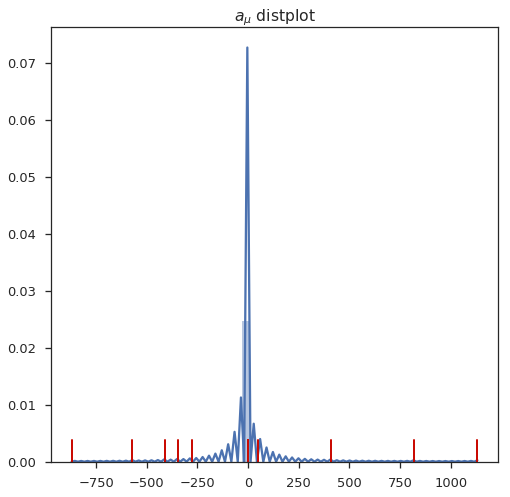

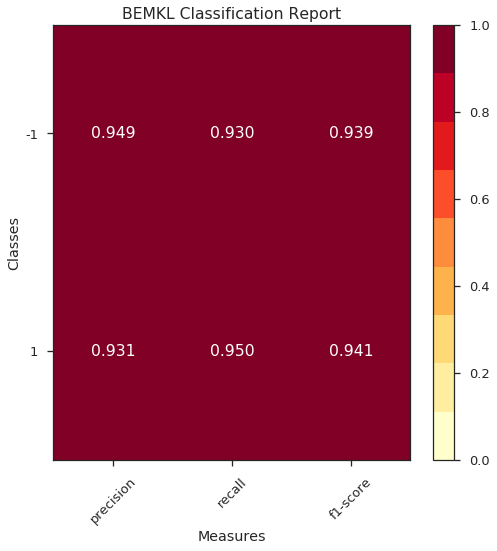

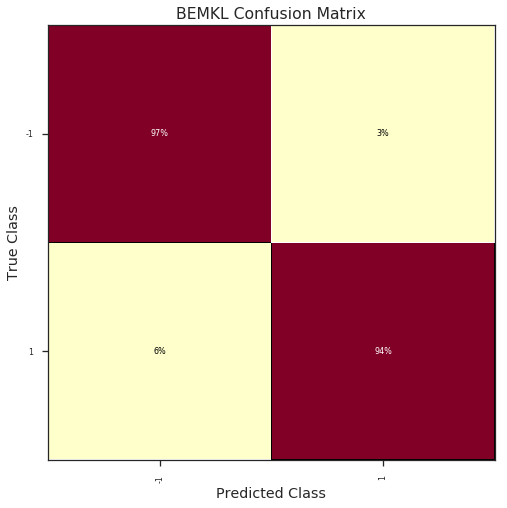

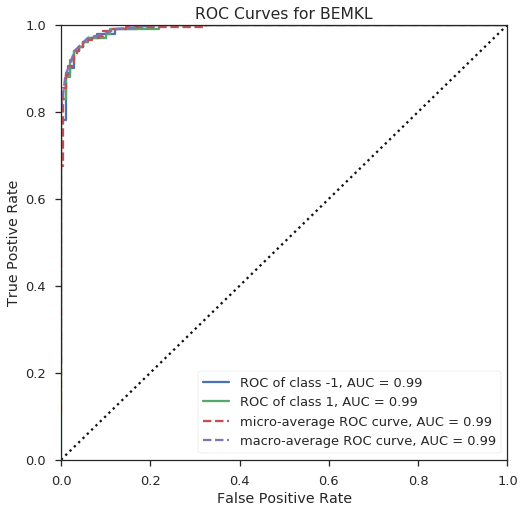

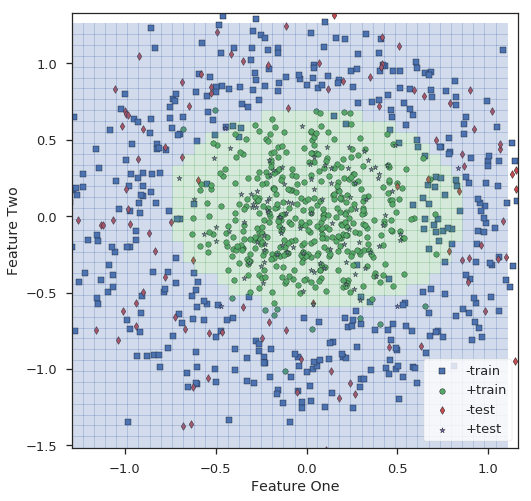

0 - Kernels: 3/39 (0.07692307692307693). SV: 655/666 (0.9834834834834835). Mean e: 1.2948. Median e: -2.5028. Std e: 5.7246. 
1 - Kernels: 3/39 (0.07692307692307693). SV: 655/666 (0.9834834834834835). Mean e: 1.2948. Median e: -2.5028. Std e: 5.7246. 
2 - Kernels: 16/39 (0.41025641025641024). SV: 648/666 (0.972972972972973). Mean e: 1.7100. Median e: 0.7363. Std e: 1.8362. 
3 - Kernels: 16/39 (0.41025641025641024). SV: 648/666 (0.972972972972973). Mean e: 1.7100. Median e: 0.7363. Std e: 1.8362. 
4 - Kernels: 5/39 (0.1282051282051282). SV: 660/668 (0.9880239520958084). Mean e: 0.7585. Median e: 0.0012. Std e: 4.5220. 
5 - Kernels: 5/39 (0.1282051282051282). SV: 660/668 (0.9880239520958084). Mean e: 0.7585. Median e: 0.0012. Std e: 4.5220. 
6 - Kernels: 11/39 (0.28205128205128205). SV: 645/666 (0.9684684684684685). Mean e: 0.3093. Median e: 0.0013. Std e: 3.1881. 
7 - Kernels: 11/39 (0.28205128205128205). SV: 645/666 (0.9684684684684685). Mean e: 0.3093. Median e: 0.0013. Std e: 3.1881.

/home/mtambos/anaconda/envs/pml/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


{'fit_time': array([ 8.5171,  7.8069,  8.4895,  8.4544,  7.4886,  7.4644]),
 'score_time': array([ 0.1208,  0.6612,  0.3175,  0.6549,  0.8271,  0.6991]),
 'test_score': array([ 0.7784,  0.7784,  0.7711,  0.7754,  0.7754,  0.7711]),
 'train_score': array([ 0.7808,  0.7853,  0.7784,  0.7853,  0.7733,  0.7889])}

In [64]:
sparse_model = BEMKL(kernels=kernels, alpha_lambda=1, beta_lambda=1, alpha_gamma=1,
                     beta_gamma=1, alpha_omega=1e-11, beta_omega=1e+9,
                     e_null_thrsh=1e-3, a_null_thrsh=1e-3)
evaluate_model(sparse_model, X, y, kernel_attrs)

## Non-Sparse Model

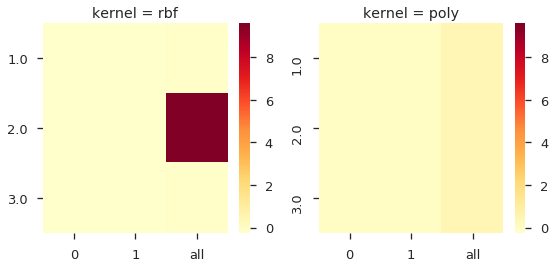

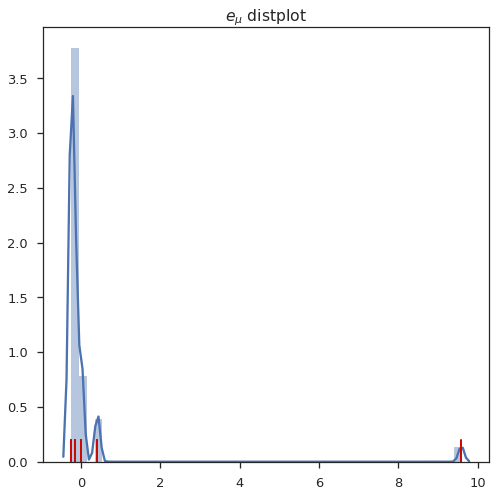

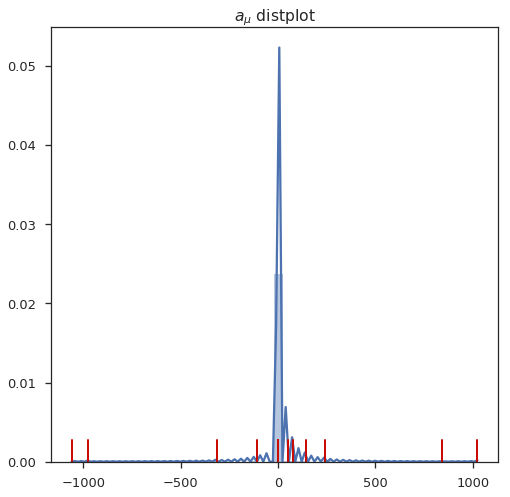

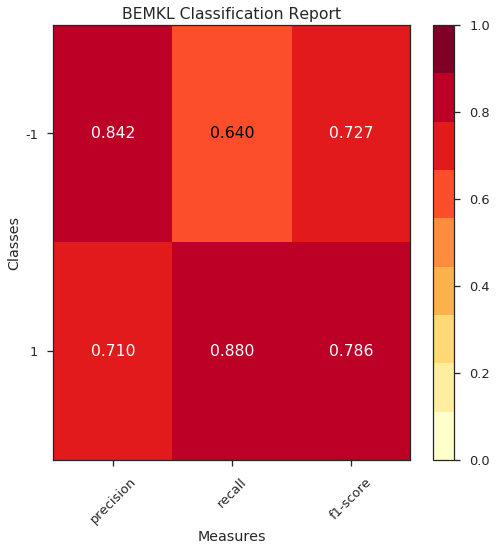

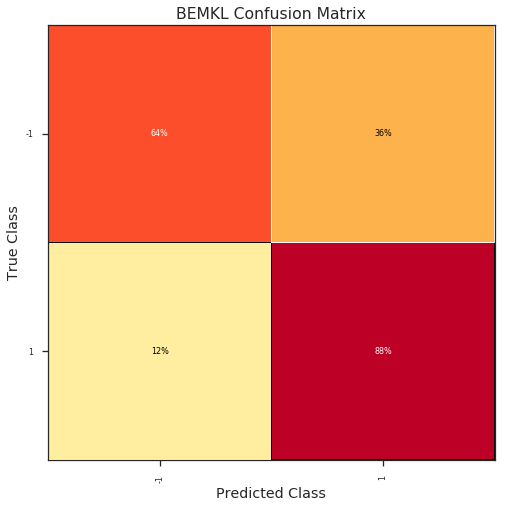

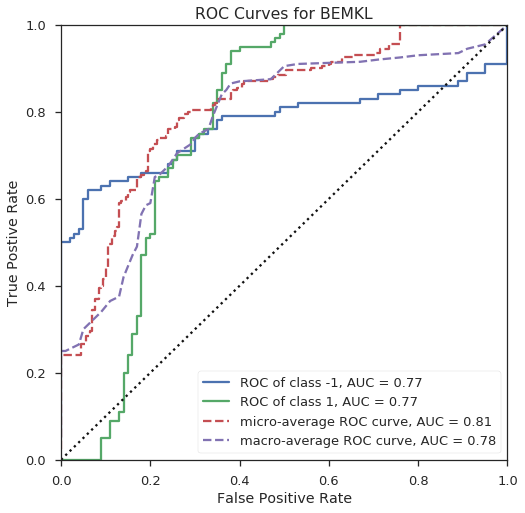

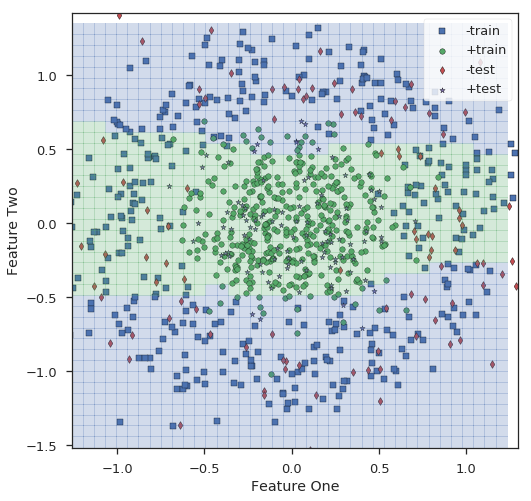

0 - Kernels: 39/39 (1.0). SV: 635/666 (0.9534534534534534). Mean e: 0.6418. Median e: -0.2875. Std e: 1.2894. 
1 - Kernels: 39/39 (1.0). SV: 635/666 (0.9534534534534534). Mean e: 0.6418. Median e: -0.2875. Std e: 1.2894. 
2 - Kernels: 39/39 (1.0). SV: 636/666 (0.954954954954955). Mean e: 0.1291. Median e: -0.9398. Std e: 1.3106. 
3 - Kernels: 39/39 (1.0). SV: 636/666 (0.954954954954955). Mean e: 0.1291. Median e: -0.9398. Std e: 1.3106. 
4 - Kernels: 39/39 (1.0). SV: 660/668 (0.9880239520958084). Mean e: 0.5328. Median e: -0.1092. Std e: 1.4802. 
5 - Kernels: 39/39 (1.0). SV: 660/668 (0.9880239520958084). Mean e: 0.5328. Median e: -0.1092. Std e: 1.4802. 
6 - Kernels: 19/39 (0.48717948717948717). SV: 647/666 (0.9714714714714715). Mean e: 1.3744. Median e: 0.3578. Std e: 1.7964. 
7 - Kernels: 19/39 (0.48717948717948717). SV: 647/666 (0.9714714714714715). Mean e: 1.3744. Median e: 0.3578. Std e: 1.7964. 
8 - Kernels: 39/39 (1.0). SV: 623/666 (0.9354354354354354). Mean e: 0.1761. Median e

/home/mtambos/anaconda/envs/pml/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


{'fit_time': array([ 7.4453,  7.7132,  7.5317,  7.5644,  7.4605,  7.3257]),
 'score_time': array([ 1.2846,  1.2882,  1.3639,  0.8554,  1.278 ,  1.3567]),
 'test_score': array([ 0.7784,  0.7814,  0.7922,  0.7844,  0.7575,  0.7922]),
 'train_score': array([ 0.7868,  0.7913,  0.7769,  0.7838,  0.7973,  0.7799])}

In [65]:
normal_model = BEMKL(kernels=kernels, alpha_lambda=1, beta_lambda=1, alpha_gamma=1,
                     beta_gamma=1, alpha_omega=1, beta_omega=1,
                     e_null_thrsh=1e-3, a_null_thrsh=1e-3)
evaluate_model(normal_model, X, y, kernel_attrs)